# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os

In [3]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [4]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_tfidf = "../../../reports/reports_nohubs/analisis_tfidf/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

# Cargo archivos

In [5]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

def load_cluster_matrices(path_infomap:str,path_louvain:str):
    tfidf_infomap = []
    tfidf_louvain = []

    for i in range(3):
        mat_path = f"{path_infomap}matriz_tfidf_infomap_{i}.npz"
        row_path = f"{path_infomap}rows_tfidf_infomap_{i}.txt"
        col_path = f"{path_infomap}cols_tfidf_infomap_{i}.txt"
        
        tfidf_infomap.append(load_sparse_dataframe(mat_path,row_path,col_path))

    for i in range(3):
        mat_path = f"{path_louvain}matriz_tfidf_louvain_{i}.npz"
        row_path = f"{path_louvain}rows_tfidf_louvain_{i}.txt"
        col_path = f"{path_louvain}cols_tfidf_louvain_{i}.txt"
        
        tfidf_louvain.append(load_sparse_dataframe(mat_path,row_path,col_path))
    
    return tfidf_infomap, tfidf_louvain

def load_node_matrices(path:str):
    document_term_matrix = []
    
    for i in range(3):
        mat_path = f"{path}matriz_nodos_tfidf_{i}.npz"
        row_path = f"{path}rows_tfidf_nodos_{i}.txt"
        col_path = f"{path}cols_tfidf_nodos_{i}.txt"

        document_term_matrix.append(load_sparse_dataframe(mat_path, row_path, col_path))
    
    return document_term_matrix

def load_node_similarity_matrices(path):
    document_similarity_matrix = []
    mat_index = f"{path}similarity_matrix_index.txt"
    for i in range(3):
        mat_path = f"{path}similaridad_nodos_tfidf_{i}.npz"
        document_similarity_matrix.append(load_sparse_dataframe(mat_path,mat_index,mat_index,cols_str=False))
    
    return document_similarity_matrix

In [6]:
#Analisis previos
infomap_clusters = pd.read_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

In [10]:
document_term_matrix = load_node_matrices(graph_data+"tfidf_nodos/")

In [11]:
infomap_dtm, louvain_dtm = load_cluster_matrices(graph_data+"tfidf_infomap/", graph_data+"tfidf_louvain/")

In [20]:
document_similarity_matrix = load_node_similarity_matrices(graph_data+"tfidf_nodos/")

In [6]:
# # Document-Term-Matrix  de clusters

# path_infomap = data_processed + "tfidf_infomap/"
# path_louvain = data_processed + "tfidf_louvain/"

# monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
# monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

# bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
# bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

# trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
# trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

# infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
# louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [6]:
# # Document-Term-Matrix de nodos
# path = data_processed + "tfidf_nodos/"
# monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
# bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
# trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

# document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

In [7]:
# # Matrices de similaridad de nodos

# path = data_processed+ "tfidf_nodos/"
# document_similarity_matrix = []

# for i in range(3):
#     matrix_path = path + "similaridad_nodos_tfidf_" + str(i) + ".npz"
#     document_similarity_matrix.append(load_sparse_dataframe(matrix_path,path+"similarity_matrix_index.txt",path+"similarity_matrix_index.txt",cols_str=False))

# Similaridad media

## Calculo y grafico

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [13]:
# def mean_similarity(similarity_matrix, cluster, algoritmo):
#     nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
#     cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
#     return round(np.mean(cluster_matrix.values), 2)

def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)

# def median_similarity_triu(similarity_matrix, cluster, algoritmo):
#     nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
#     cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster].values
#     indices = np.triu_indices_from(cluster_matrix,1)
#     values = cluster_matrix[indices]
#     return round(np.median(values), 2)

def get_similarity(document_term_matrix,df=True):
    ids = document_term_matrix.index.values
    scores = sparse.csr_matrix(document_term_matrix.values)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

Armo matrices de similaridad y las guardo en formato sparse

In [14]:
# document_similarity_matrix = []
# for dtm in document_term_matrix:
#     document_similarity_matrix.append(get_similarity(dtm,False))

In [17]:
# path = graph_data+"tfidf_nodos/"
# ids = document_term_matrix[0].index.values
# np.savetxt(path+"similarity_matrix_index.txt",ids)

# for i,vals in enumerate(document_similarity_matrix):
#     sparse.save_npz(f"{path}similaridad_nodos_tfidf_{i}.npz",vals)

Calculo similaridad media

In [22]:
similarity_cases = ["mean_similarity_mono_triu","mean_similarity_bi_triu","mean_similarity_tri_triu"]
for i,case in enumerate(similarity_cases):
    infomap_similarity = pd.Series({cluster:mean_similarity_triu(document_similarity_matrix[i], cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name=case)
    louvain_similarity = pd.Series({cluster:mean_similarity_triu(document_similarity_matrix[i], cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name=case)

    infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
    louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

In [24]:
# infomap_clusters.to_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

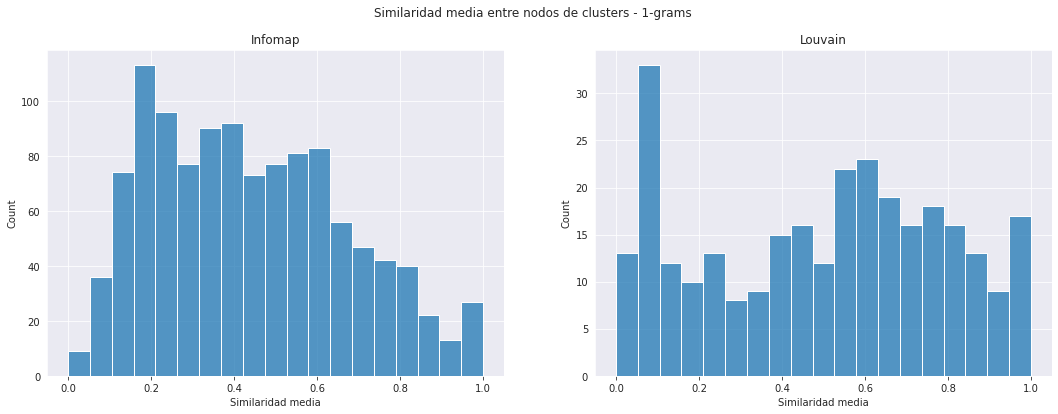

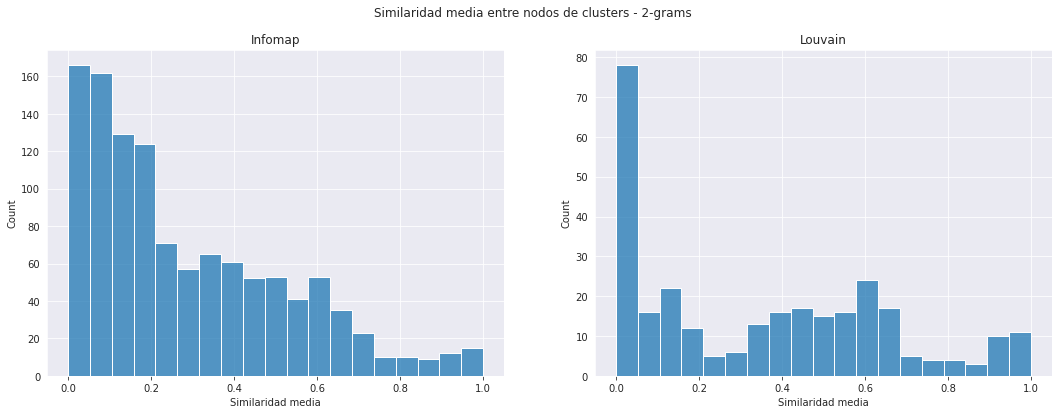

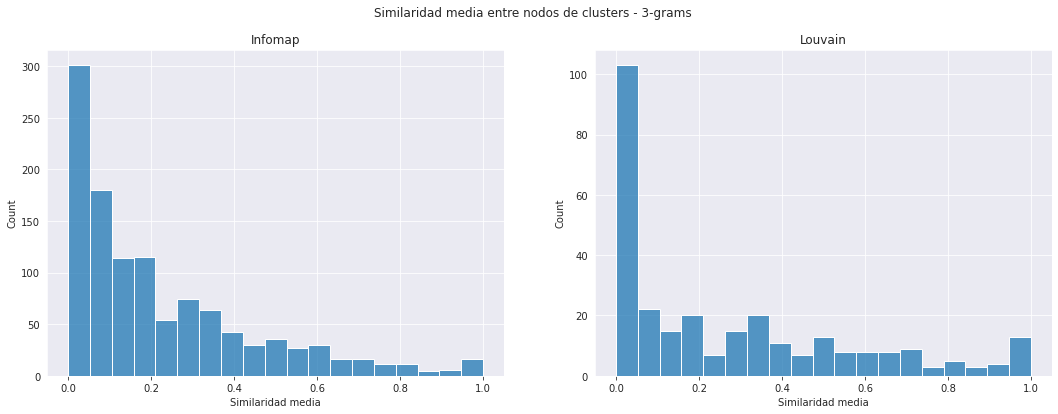

In [8]:
similarity_cases = ["mean_similarity_mono_triu","mean_similarity_bi_triu","mean_similarity_tri_triu"]
# similarity_cases = ["mean_similarity_mono","mean_similarity_bi","mean_similarity_tri"]

for i, case in enumerate(similarity_cases):
    fig, ax = plt.subplots(1,2,figsize=(18,6))
    fig.suptitle(f"Similaridad media entre nodos de clusters - {i+1}-grams")
    # ticks = np.logspace(0,tamaños_infomap.max(),10)

    sns.histplot(data=infomap_clusters[case], ax=ax[0], bins=np.linspace(0,1,20))
    ax[0].set_xlabel("Similaridad media")
    ax[0].set_title("Infomap")

    sns.histplot(data=louvain_clusters[case], ax=ax[1],bins=np.linspace(0,1,20))
    ax[1].set_xlabel("Similaridad media")
    ax[1].set_title("Louvain")

## Similaridad de todos los nodos

In [25]:
# similaridad_todos = cosine_similarity(sparse.csr_matrix(document_term_matrix[0].values),sparse.csr_matrix(document_term_matrix[0].values),True)
# similaridad_todos_indices = np.triu_indices_from(similaridad_todos,1)
# similaridad_todos_values = similaridad_todos[similaridad_todos_indices]

Text(0, 0.5, 'Density')

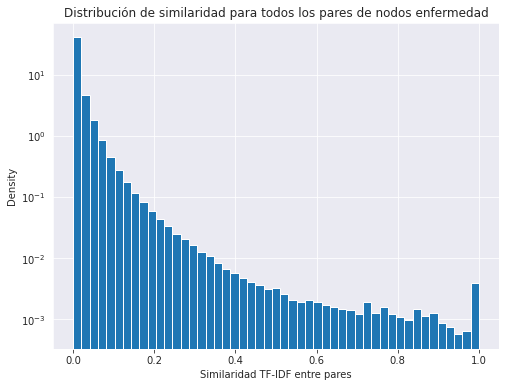

In [26]:
# plt.figure(figsize=(8,6))
# plot = plt.hist(similaridad_todos_values,bins=np.linspace(0,1,50),log=True, density=True)
# plt.title("Distribución de similaridad para todos los pares de nodos enfermedad")
# plt.xlabel("Similaridad TF-IDF entre pares")
# plt.ylabel("Density")
# plt.savefig(tfidf_reports+"similaridad_todos.png",dpi=200)

## P valores por cluster

Dado un cluster C de tamaño N:

+ Calculo su similaridad media y mediana
num_mayores = 0

repeat 100 veces:

    tomo N nodos al azar del grafo 

    calculo su similaridad media y mediana

    si el estadístico random es mayor al medido: num_mayores + 1
    
    else: nada

valor = num_mayores/100
reporto valor para cada cluster

In [27]:
node_indexes = disease_attributes.node_index.values
mean_cases = ["mean_similarity_mono_triu","mean_similarity_bi_triu","mean_similarity_tri_triu"]
iters = 1000

i = 0

pvalues_infomap = {}
total_clusters = len(infomap_clusters)
for k,cluster in enumerate(infomap_clusters.comunidad.values):
    size = infomap_clusters.set_index("comunidad").loc[cluster,"tamaño"]

    #Los estadísticos para el cluster ya los tengo calculados
    media = infomap_clusters.set_index("comunidad").loc[cluster,mean_cases[i]]
    mean_counts = 0

    for n in range(iters):
        random_cluster = np.random.choice(node_indexes,size)
        random_cluster_similarity_matrix = document_similarity_matrix[i].loc[random_cluster,random_cluster].values
        indices = np.triu_indices_from(random_cluster_similarity_matrix,1)
        values = random_cluster_similarity_matrix[indices]
        media_random = round(np.mean(values), 2)
        if media_random > media:
            mean_counts += 1

    pvalue_mean = mean_counts/iters

    pvalues_infomap[cluster] = pvalue_mean
    if k%10 == 0:
        print(f"Cluster {k} of {total_clusters} - Infomap")


pvalues_louvain = {}
total_clusters = len(louvain_clusters)
for k,cluster in enumerate(louvain_clusters.comunidad.values):
    size = louvain_clusters.set_index("comunidad").loc[cluster,"tamaño"]

    #Los estadísticos para el cluster ya los tengo calculados
    media = louvain_clusters.set_index("comunidad").loc[cluster,mean_cases[i]]
    mean_counts = 0

    for n in range(iters):
        random_cluster = np.random.choice(node_indexes,size)
        random_cluster_similarity_matrix = document_similarity_matrix[i].loc[random_cluster,random_cluster].values
        indices = np.triu_indices_from(random_cluster_similarity_matrix,1)
        values = random_cluster_similarity_matrix[indices]
        media_random = round(np.mean(values), 2)
        if media_random > media:
            mean_counts += 1

    pvalue_mean = mean_counts/iters

    pvalues_louvain[cluster] = pvalue_mean
    if k%10 == 0:
        print(f"Cluster {k} of {total_clusters}")

Cluster 0 of 1148 - Infomap


KeyboardInterrupt: 

Ver estandarización con Z score

In [25]:
pvalues_infomap_series = pd.Series(pvalues_infomap, index=pvalues_infomap.keys(), name="pvalor")
pvalues_louvain_series = pd.Series(pvalues_louvain, index=pvalues_louvain.keys(), name="pvalor")

In [33]:
infomap_clusters = pd.concat([infomap_clusters, pvalues_infomap_series], axis=1)
louvain_clusters = pd.concat([louvain_clusters, pvalues_louvain_series], axis=1)

# infomap_clusters.to_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [34]:
infomap_clusters.columns

Index(['comunidad', 'tamaño', 'mean_similarity_mono', 'mean_similarity_bi',
       'mean_similarity_tri', 'entropia_1', 'entropia_2', 'entropia_3',
       'top_monogram', 'top_monogram_score', 'top_bigram', 'top_bigram_score',
       'top_trigram', 'top_trigram_score', 'top_5_monograms', 'top_5_bigrams',
       'top_5_trigrams', 'top_5_monograms_score', 'top_5_bigrams_score',
       'top_5_trigrams_score', 'mean_similarity_mono_triu',
       'mean_similarity_bi_triu', 'mean_similarity_tri_triu', 'pvalor'],
      dtype='object')

In [36]:
fig = px.histogram(louvain_clusters, x="pvalor")
fig.show()

Text(0.5, 0, 'P-values')

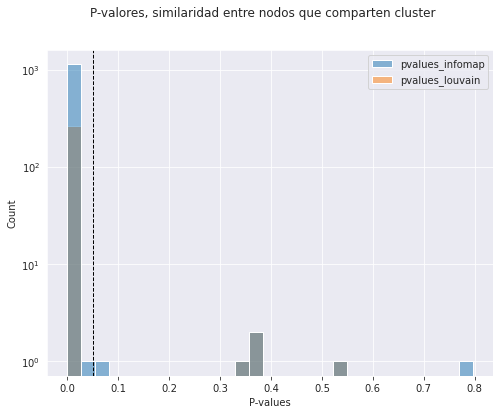

In [41]:
data = pd.DataFrame([pvalues_infomap.values(),pvalues_louvain.values()]).T.rename(columns={0:"pvalues_infomap",1:"pvalues_louvain"})
fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,data.max().max(),30),log_scale=(False,True))
fig.suptitle("P-valores, similaridad entre nodos que comparten cluster")
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel("P-values")

In [58]:
outliers_infomap = infomap_clusters[infomap_clusters.pvalor > 0.05]
outliers_louvain = louvain_clusters[louvain_clusters.pvalor > 0.05]

In [59]:
outliers_infomap

,comunidad,tamaño,mean_similarity_mono,mean_similarity_bi,mean_similarity_tri,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,...,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score,mean_similarity_mono_triu,mean_similarity_bi_triu,mean_similarity_tri_triu,pvalor
271,169,14,0.31,0.18,0.17,0.54,0.48,0.38,lymphoproliferative,0.39,...,"[lymphoproliferative, ebv, lymphohistiocytosis...","[associate lymphoproliferative, hemophagocytic...","[recessive primary immunodeficiency, autosomal...","[0.39, 0.27, 0.24, 0.24, 0.24]","[0.29, 0.27, 0.25, 0.23, 0.22]","[0.39, 0.35, 0.32, 0.32, 0.27]",0.26,0.12,0.12,0.797
773,633,6,0.51,0.38,0.44,0.48,0.40,0.24,myeloid,0.60,...,"[myeloid, leukemia, acute, blast, bruising]","[acute myeloid, myeloid leukemia, recurrent ge...","[acute myeloid leukemia, clonal proliferation ...","[0.6, 0.4, 0.25, 0.18, 0.15]","[0.52, 0.52, 0.16, 0.16, 0.16]","[0.86, 0.25, 0.25, 0.23, 0.17]",0.42,0.26,0.33,0.079
1037,1122,3,0.95,0.84,0.44,0.11,0.06,NaN,pituitary,0.71,...,"[pituitary, adenoma, multiple, panhypopituitar...","[pituitary adenoma, adenoma pituitary, 19p13 r...","[abcc8 chromosome familial, neurocutaneous cha...","[0.71, 0.66, 0.26, 0.0, 0.0]","[0.94, 0.33, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.93,0.76,0.33,0.527
1126,983,2,1.00,0.00,0.00,0.08,NaN,NaN,aneurysm,0.76,...,"[aneurysm, intracranial, 10p13, palpebrae, pank2]","[19p13 rare, normal rare, normal tissue, norma...","[abcc8 chromosome familial, neurocutaneous cha...","[0.76, 0.66, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.371
1129,1092,2,0.64,0.53,0.50,0.37,0.28,0.00,retinal,0.50,...,"[retinal, cd, exudate, telangiectasia, unilate...","[potentially lead, idiopathic characterize, ch...","[small blood vessel, abcc8 chromosome familial...","[0.5, 0.38, 0.28, 0.26, 0.26]","[0.36, 0.35, 0.34, 0.33, 0.3]","[1.0, 0.0, 0.0, 0.0, 0.0]",0.28,0.05,0.00,0.343
1130,1137,2,0.96,0.77,0.00,0.25,0.07,NaN,scleral,0.54,...,"[staphyloma, scleral, uveal, thickness, protru...","[defect posterior, defect eye, 19p13 rare, nor...","[abcc8 chromosome familial, neurocutaneous cha...","[0.54, 0.54, 0.3, 0.3, 0.27]","[0.76, 0.65, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.91,0.54,0.00,0.371


# Entropía

### Cargo entropías random

In [11]:
paths_infomap = [reports_tfidf+"entropia_random_infomap_"+case+".txt" for case in ["mono","bi","tri"]]
paths_louvain = [reports_tfidf+"entropia_random_louvain_"+case+".txt" for case in ["mono","bi","tri"]]

entropias_random_infomap = {n:np.loadtxt(path) for n,path in enumerate(paths_infomap)}
entropias_random_louvain = {n:np.loadtxt(path) for n,path in enumerate(paths_louvain)}

means_random_infomap = {}
stds_random_infomap = {}

for i,res in entropias_random_infomap.items():
    means = [np.mean(arr) for arr in np.array(res).T]
    stds = [np.std(arr) for arr in np.array(res).T]

    means_random_infomap[i] = means
    stds_random_infomap[i] = stds


means_random_louvain = {}
stds_random_louvain = {}

for i,res in entropias_random_louvain.items():
    means = [np.mean(arr) for arr in np.array(res).T]
    stds = [np.std(arr) for arr in np.array(res).T]

    means_random_louvain[i] = means
    stds_random_louvain[i] = stds

In [12]:
ids_random_infomap = infomap_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_infomap = infomap_clusters.set_index("comunidad").loc[ids_random_infomap,"tamaño"].values

ids_random_louvain = louvain_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_louvain = louvain_clusters.set_index("comunidad").loc[ids_random_louvain,"tamaño"].values

### Calculo entropías medidas

In [13]:
infomap_clusters_temp = infomap_clusters.copy()
infomap_clusters_mean_s = infomap_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).mean().fillna(0)
infomap_clusters_std_s = infomap_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).std().fillna(0)

louvain_clusters_temp = louvain_clusters.copy()
louvain_clusters_mean_s = louvain_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).mean().fillna(0)
louvain_clusters_std_s = louvain_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).std().fillna(0)

### Graficos de entropía medida vs entropía random

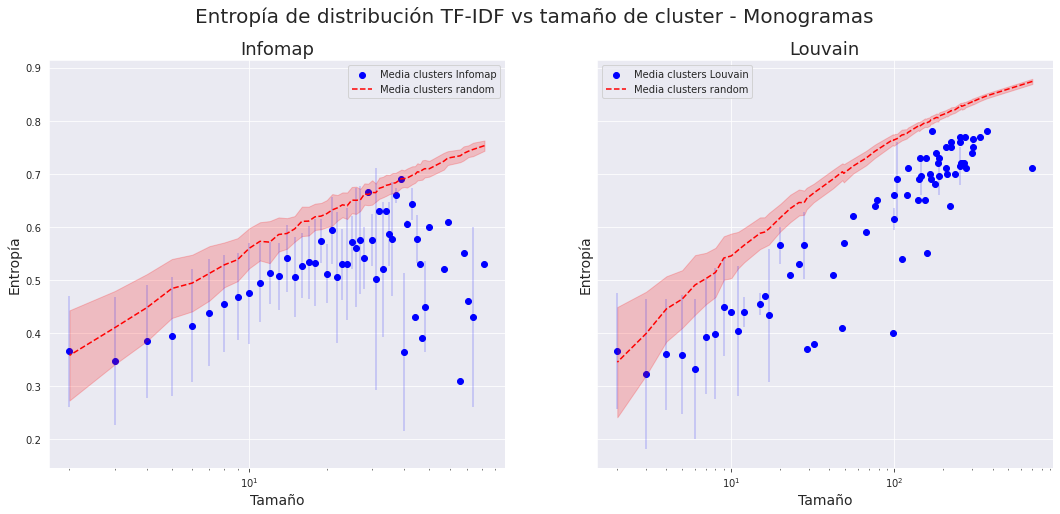

In [16]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=False, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster - Monogramas",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

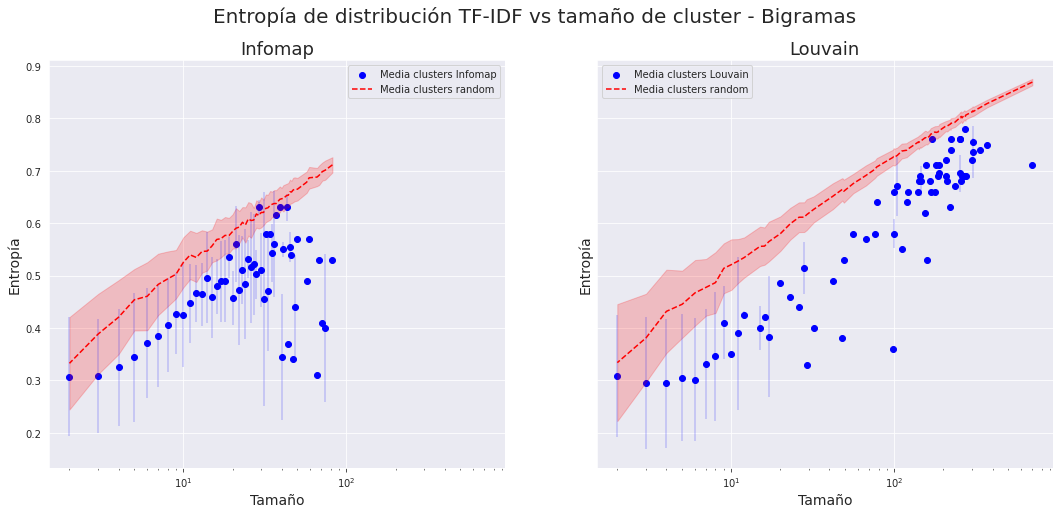

In [17]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_2.values, infomap_clusters_std_s.entropia_2.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[1]),  np.array(stds_random_infomap[1])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster - Bigramas",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_2.values, louvain_clusters_std_s.entropia_2.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[1]), np.array(stds_random_louvain[1])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

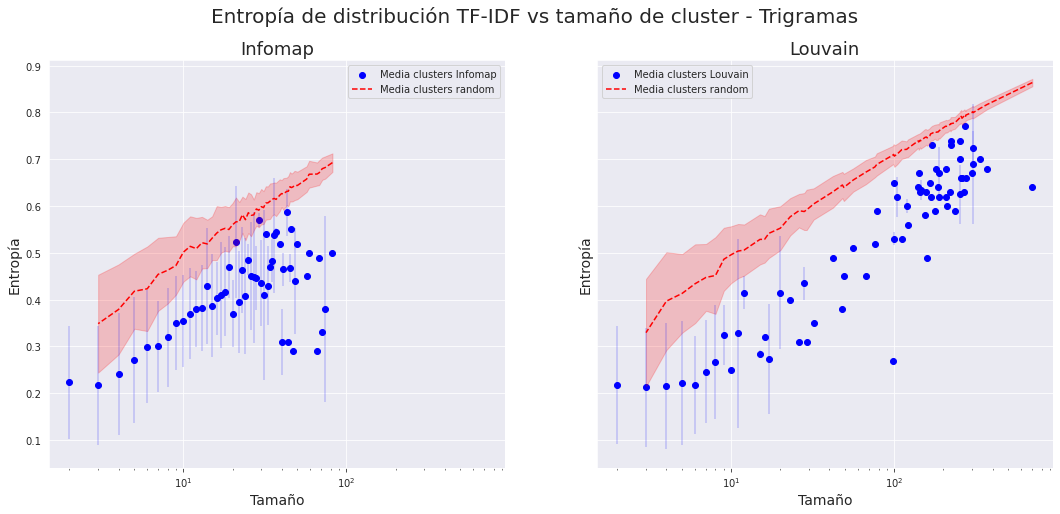

In [18]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_3.values, infomap_clusters_std_s.entropia_3.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[2]),  np.array(stds_random_infomap[2])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster - Trigramas",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_3.values, louvain_clusters_std_s.entropia_3.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[2]), np.array(stds_random_louvain[2])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

#### Versión vieja por si hay que cambiarlo

In [ ]:
# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].plot(x1 , y1, "bo", label="Media clusters Infomap")
# ax[0].fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

# ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
# ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].plot(x2 , y2, "bo", label="Media clusters Louvain")
# ax[1].fill_between(x2, y2 - std2, y2 + std2, color='b', alpha=0.2)

# ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
# ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()


# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].scatter(x1 , y1, c="b", label="Media clusters Infomap")
# ax[0].errorbar(x1, y1,std1, color='b', alpha=0.2)

# ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
# ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].scatter(x2 , y2, c="b", label="Media clusters Louvain")
# ax[1].errorbar(x2, y2, std2, color='b', alpha=0.2)

# ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
# ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()

# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].scatter(x1 , y1, c="b", label="Media clusters Infomap")
# ax[0].errorbar(x1, y1,std1, color='b', alpha=0.2)

# ax[0].scatter(x1_random , y1_random, c="r", label="Media clusters random")
# ax[0].errorbar(x1_random, y1_random, std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].scatter(x2 , y2, c="b", label="Media clusters Louvain")
# ax[1].errorbar(x2, y2, std2, color='b', alpha=0.2)

# ax[1].scatter(x2_random , y2_random, c="r", label="Media clusters random")
# ax[1].errorbar(x2_random, y2_random, std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()

#### Los dos juntos, por si hay que cambiarlo

/tmp/ipykernel_10984/2140290852.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x2_random , y2_random, "r--",linestyle='None', label="Media clusters random")


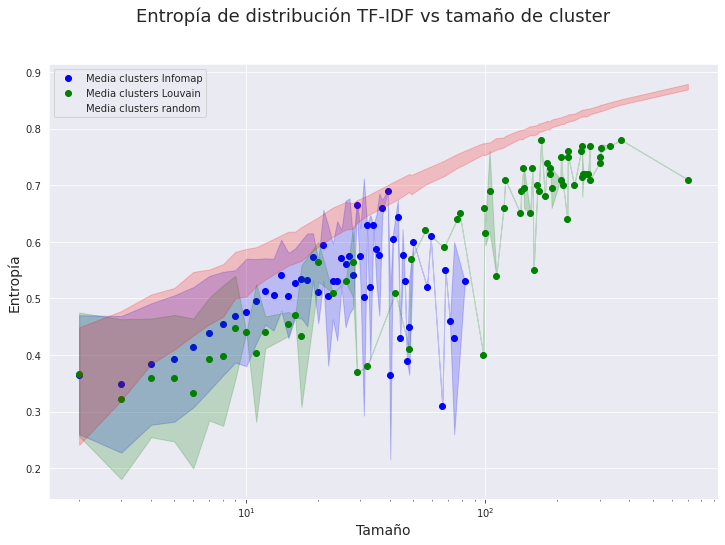

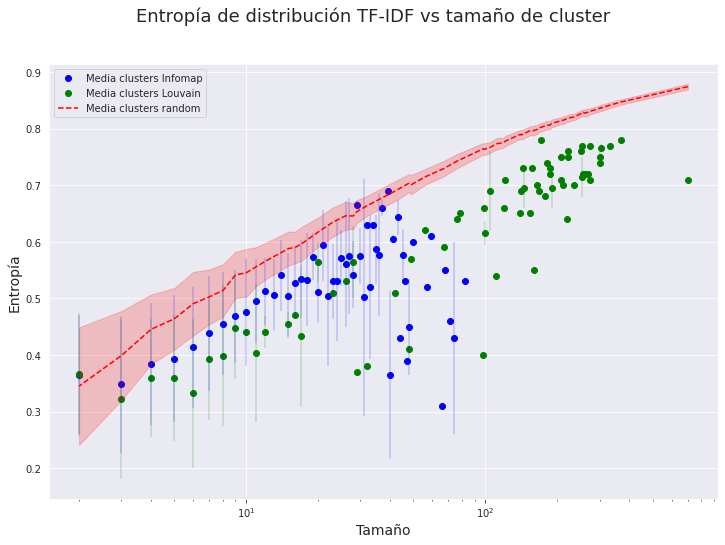

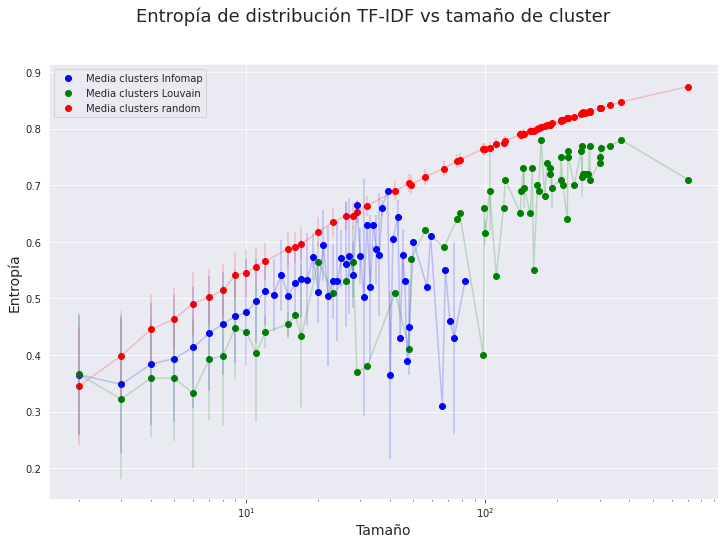

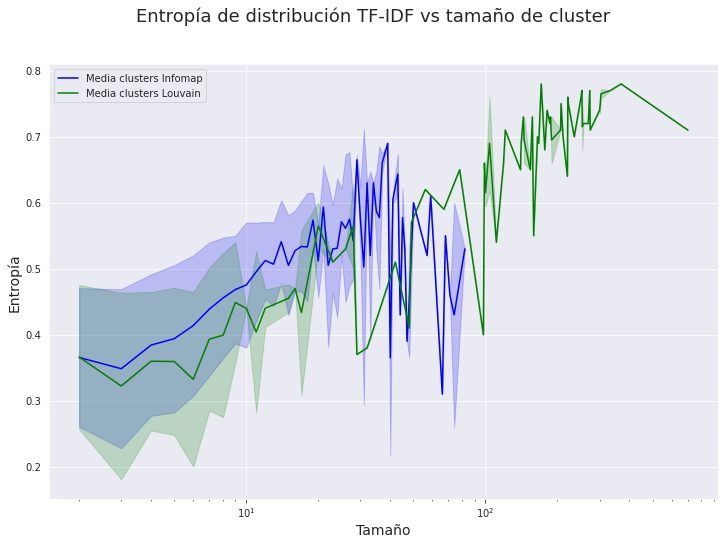

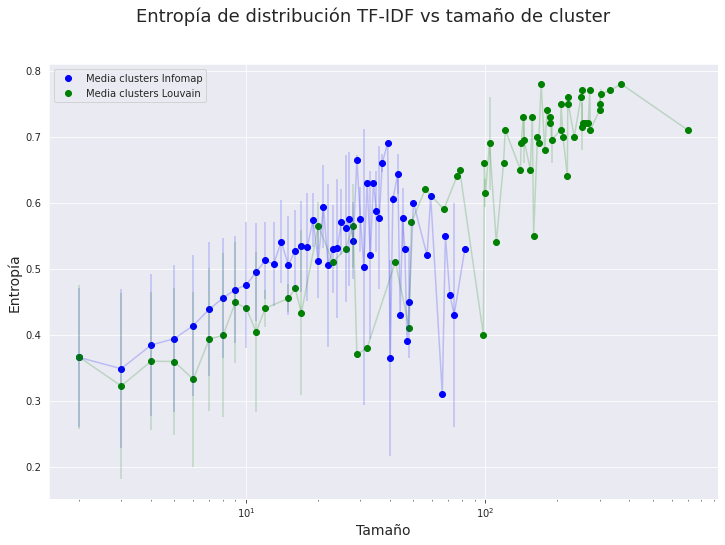

In [19]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values

x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, color="b",linestyle='None', label="Media clusters Infomap")
ax.fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, color= "g",linestyle='None', label="Media clusters Louvain")
ax.fill_between(x2, y2 - std2, y2 + std2, color='g', alpha=0.2)

ax.plot(x2_random , y2_random, "r--",linestyle='None', label="Media clusters random")
ax.fill_between(x2_random, y2_random - std2_random, y2_random + std2_random,linestyle='None', color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b',linestyle='None', alpha=0.2)

ax.scatter(x2 , y2, c="g",linestyle='None', label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g',linestyle='None', alpha=0.2)

ax.plot(x2_random , y2_random, "r--", label="Media clusters random")
ax.fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()


fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b", label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, c="g", label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g', alpha=0.2)

ax.scatter(x2_random , y2_random, c="r", label="Media clusters random")
ax.errorbar(x2_random, y2_random, std2_random, color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.plot(x1 , y1, "b-", label="Media clusters Infomap")
ax.fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

ax.plot(x2 , y2, "g-", label="Media clusters Louvain")
ax.fill_between(x2, y2 - std2, y2 + std2, color='g', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b", label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, c="g", label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

# Super gráfico

Eje x: entropía 
Eje y: similaridad media
Tamaño de punto: tamaño de cluster

In [34]:
infomap_clusters.columns

Index(['comunidad', 'tamaño', 'entropia_1', 'entropia_2', 'entropia_3',
       'top_monogram', 'top_monogram_score', 'top_bigram', 'top_bigram_score',
       'top_trigram', 'top_trigram_score', 'top_5_monograms', 'top_5_bigrams',
       'top_5_trigrams', 'top_5_monograms_score', 'top_5_bigrams_score',
       'top_5_trigrams_score', 'mean_similarity_mono_triu',
       'mean_similarity_bi_triu', 'mean_similarity_tri_triu'],
      dtype='object')

In [39]:
fig = px.scatter(infomap_clusters, x="entropia_1", y="mean_similarity_mono_triu", size="tamaño",width=1000, height=600, title="Entropía vs similaridad media vs tamaño",marginal_x="histogram",marginal_y="histogram")
fig.update_layout(xaxis_title="Entropía", yaxis_title="Similaridad media - monogramas")

fig.show()

Hacer similaridad Jaccard con genes. Comparar con estas métricas. Se puede ver nodo contra nodo o por cluster (tomando la media)

Agregar a la super tabla

Agregar a diapo de comparación de particiones. Poner los dos en un mismo gráfico.

In [36]:
fig = px.scatter(louvain_clusters, x="entropia_1", y="mean_similarity_mono_triu", size="tamaño",width=1000, height=600, title="Entropía vs similaridad media vs tamaño",marginal_x="histogram",marginal_y="histogram")
fig.update_layout(xaxis_title="Entropía", yaxis_title="Similaridad media - monogramas")

fig.show()